In [0]:
#header files
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd 
import numpy as np

import keras_vggface
#vggFace
from keras_vggface.vggface import VGGFace

import keras
#model layers
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

#processing and optimizer header
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

import matplotlib
#matplotlib
import matplotlib.pyplot as plt

#header files for preprocessing of image we want to recognize
from keras.models import load_model
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras_vggface.utils import preprocess_input

In [70]:
#versions

print("TensorFlow Version:",tf.__version__)
print("Keras Version:",keras.__version__)
print("Keras-VGGface Version:",keras_vggface.__version__)
print("Matplotlib Version:",matplotlib.__version__)
print("Numpy Version:",np.__version__)
print("Pandas Version:",pd.__version__)

TensorFlow Version: 1.15.0-rc3
Keras Version: 2.2.5
Keras-VGGface Version: 0.6
Matplotlib Version: 3.0.3
Numpy Version: 1.16.5
Pandas Version: 0.24.2


In [6]:
#loading the pretrained model VGG16
  
pre_trained_model=VGGFace(input_shape=(224, 224, 3),model='vgg16',weights='vggface',include_top=False) 



In [7]:
print("[OUT]: The model Summary befor making layers non-trainable")
print(pre_trained_model.summary())

[OUT]: The model Summary befor making layers non-trainable
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
____________________________________________________________

In [0]:
#making layers non trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

In [9]:
print("[OUT]:Summary after making layers non-trainable.")
print(pre_trained_model.summary())


[OUT]:Summary after making layers non-trainable.
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool

In [0]:
#since we  need to recognize total 6 faces (me + 5 others)
total_person=6
model_last_layer = pre_trained_model.get_layer('pool5').output

In [0]:
#now we need to define our own final layers for recognition

custom_layer=Flatten(name='Flatten')(model_last_layer)
custom_layer=Dense(1024,activation='relu',name="custom_fc6")(custom_layer)
custom_layer=Dense(1024,activation='relu',name="custom_fc7")(custom_layer)
final_output=Dense(total_person,activation='softmax',name="final_6person_fc8")(custom_layer)

#final_model
custom_final_model=Model(pre_trained_model.input,final_output)


In [13]:
print("[OUT]: Final Custom model Summary:")
print(custom_final_model.summary())

[OUT]: Final Custom model Summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)    

In [15]:
#processing image and generating more  data from images

batch_size = 5
train_data_path = '/Data/train/'
test_data_path = '/Data/test/'

train_data_generator = ImageDataGenerator(rescale=1.0/255.0,horizontal_flip=True,shear_range=0.2,zoom_range=0.2)

test_data_generator = ImageDataGenerator(rescale=1.0/255.0,horizontal_flip=True,shear_range=0.2,zoom_range=0.2)

train_data = train_data_generator.flow_from_directory(directory=train_data_path,target_size=(224,224),
                                                      batch_size=batch_size,class_mode='sparse',color_mode='rgb',shuffle=True)

test_data =  test_data_generator.flow_from_directory(directory=test_data_path,target_size=(224,224),
                                                      batch_size=batch_size,class_mode='sparse',color_mode='rgb')
    



Found 60 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


In [18]:
#compiling model
custom_final_model.compile(loss='sparse_categorical_crossentropy',optimizer=SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])



In [19]:
#training model on generated data

model_history = custom_final_model.fit_generator(train_data,validation_data=test_data,steps_per_epoch=50/batch_size,
                                          validation_steps=test_data.n,epochs=50)

custom_final_model.evaluate_generator(generator=test_data)
        


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
10/10 [==============================] - 39s 4s/step - loss: 1.7864 - acc: 0.1800 - val_loss: 1.7892 - val_acc: 0.2033
Epoch 2/50
10/10 [==============================] - 12s 1s/step - loss: 1.7855 - acc: 0.2600 - val_loss: 1.7861 - val_acc: 0.2133
Epoch 3/50
10/10 [==============================] - 9s 858ms/step - loss: 1.7688 - acc: 0.2400 - val_loss: 1.7818 - val_acc: 0.2467
Epoch 4/50
10/10 [==============================] - 9s 879ms/step - loss: 1.7721 - acc: 0.3400 - val_loss: 1.7753 - val_acc: 0.2933
Epoch 5/50
10/10 [==============================] - 9s 877ms/step - loss: 1.7607 - acc: 0.3000 - val_loss: 1.7701 - val_acc: 0.3300
Epoch 6/50
10/10 [==============================] - 8s 833ms/step - loss: 1.7542 - acc: 0.4200 - val_loss: 1.7682 - val_acc: 0.3467
Epoch 7/50
10/10 [==============================] - 8s 837ms/step - loss: 1.7467 - acc: 0.5200 - val_loss: 1.7618 - 

[1.5132336815198262, 0.8833333402872086]

In [0]:
#saving model
custom_final_model.save('/Data/Custom_6_face_reco.h5')

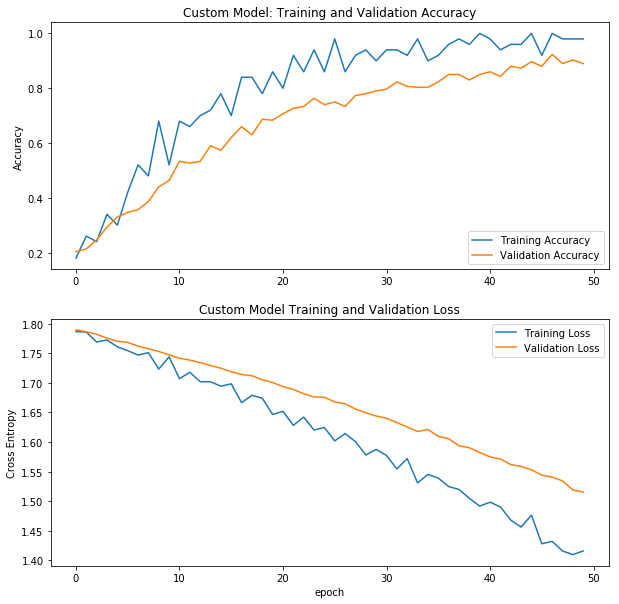

In [28]:
#plotting training and validation accuracy and loss

acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

#training and validation accuracy 
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Custom Model: Training and Validation Accuracy')

#training and validation accuracy 
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Custom Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


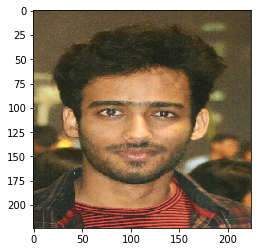

In [36]:
#my image after converting to  size 224*224

test1_img = load_img('/Data/Prediction_Images/Test_1.jpg',target_size=(224, 224))

plt.imshow(test1_img)



In [38]:

#preprocess image
img = img_to_array(test1_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

#prediction using custom model 
all_predictions = custom_final_model.predict(img)
predicted_class=np.argmax(all_predictions,axis=1)

#getting labels
labels = (train_data.class_indices)
labels = dict((indx,lab) for lab,indx in labels.items())
predictions = [labels[indx] for indx in predicted_class]

#show label after predictions


print("[OUT]:The person in the image is : ",predictions)


[OUT]:The person in the image is :  ['Vishal_Dhiman']


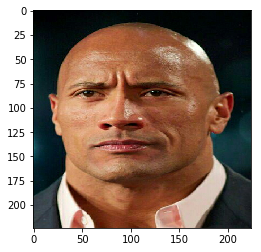

In [39]:
#Dwayne Johnson(The Rock) Image after converting to  size 224*224

test2_img = load_img('/Data/Prediction_Images/Test_2.jpg',target_size=(224, 224))

plt.imshow(test2_img)

In [40]:
#preprocess image
img = img_to_array(test2_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

#prediction using custom model 
all_predictions = custom_final_model.predict(img)
predicted_class=np.argmax(all_predictions,axis=1)

#getting labels
labels = (train_data.class_indices)
labels = dict((indx,lab) for lab,indx in labels.items())
predictions = [labels[indx] for indx in predicted_class]

#show label after predictions


print("[OUT]:The person in the image is : ",predictions)

[OUT]:The person in the image is :  ['Dwayne_Johnson']


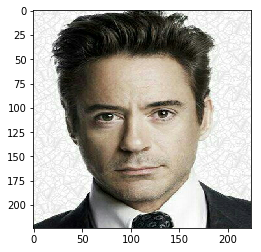

In [42]:
#Robert Downey Image after converting to  size 224*224

test3_img = load_img('/Data/Prediction_Images/Test_3.jpg',target_size=(224, 224))

plt.imshow(test3_img)

In [47]:
#preprocess image
img = img_to_array(test3_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

#prediction using custom model 
all_predictions = custom_final_model.predict(img)
predicted_class=np.argmax(all_predictions,axis=1)

#getting labels
labels = (train_data.class_indices)
labels = dict((indx,lab) for lab,indx in labels.items())
predictions = [labels[indx] for indx in predicted_class]

#show label after predictions


print("[OUT]:The person in the image is : ",predictions)

[OUT]:The person in the image is :  ['Robert_Downey']


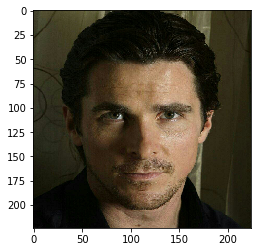

In [43]:
#Christian Bale : Image after converting to  size 224*224

test4_img = load_img('/Data/Prediction_Images/Test_4.jpg',target_size=(224, 224))

plt.imshow(test4_img)

In [48]:
#preprocess image
img = img_to_array(test4_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

#prediction using custom model 
all_predictions = custom_final_model.predict(img)
predicted_class=np.argmax(all_predictions,axis=1)

#getting labels
labels = (train_data.class_indices)
labels = dict((indx,lab) for lab,indx in labels.items())
predictions = [labels[indx] for indx in predicted_class]

#show label after predictions


print("[OUT]:The person in the image is : ",predictions)

[OUT]:The person in the image is :  ['Christian_Bale']


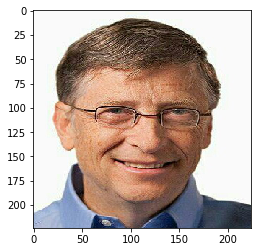

In [52]:
#Bill Gates : Image after converting to  size 224*224

test5_img = load_img('/Data/Prediction_Images/Test_5.jpg',target_size=(224, 224))

plt.imshow(test5_img)

In [55]:
#preprocess image
img = img_to_array(test5_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

#prediction using custom model 
all_predictions = custom_final_model.predict(img)
predicted_class=np.argmax(all_predictions,axis=1)

#getting labels
labels = (train_data.class_indices)
labels = dict((indx,lab) for lab,indx in labels.items())
predictions = [labels[indx] for indx in predicted_class]

#show label after predictions


print("[OUT]:The person in the image is : ",predictions)

[OUT]:The person in the image is :  ['Bill_Gates']


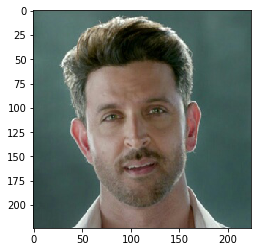

In [54]:
#Hrithik Roshan: Image after converting to  size 224*224

test6_img = load_img('/Data/Prediction_Images/Test_6.jpg',target_size=(224, 224))

plt.imshow(test6_img)

In [56]:
#preprocess image
img = img_to_array(test6_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

#prediction using custom model 
all_predictions = custom_final_model.predict(img)
predicted_class=np.argmax(all_predictions,axis=1)

#getting labels
labels = (train_data.class_indices)
labels = dict((indx,lab) for lab,indx in labels.items())
predictions = [labels[indx] for indx in predicted_class]

#show label after predictions


print("[OUT]:The person in the image is : ",predictions)

[OUT]:The person in the image is :  ['Hrithik_Roshan']
